# Restauração de Imagens - Filtro de Wiener


O filtro de Wiener é aplicado em processamento de imagens para a remoção de ruídos, realizada com base em uma análise estatística que considera o ruído como uma variável aleatória e busca estimar o mínimo erro quadrático entre a imagem estimada (resultante da análise do mínimo erro quadrático) e a imagem original

Nesse notebook, buscamos obter um coeficiente de balanço para o filtro de Wiener que minimize a Raíz Quadrada do Erro Médio (RMSE) entre a imagem restaurada e a imagem original, fazendo isso através da automatização da geração dos coeficientes de balanço e do cálculo da RMSE para cada imagem resultante da aplicação do filtro para cada coeficiente. Uma vez tendo os valores computados, analisamos qual dos coeficientes apresentou o menor RMSE e então recuperamos a imagem relacionada a ele para compararmos com a imagem original e com a degradada

## Bibliotecas utilizadas

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage import restoration
from math import sqrt, ceil
from scipy.signal import convolve2d

## Funções

### Raíz Quadrada do Erro Médio (Root Mean Squared Error - RMSE)

Para avaliar a similaridade entre a imagem resultante da aplicação do filtro de Wiener utilizamos a abordagem da Raíz Quadrada do Erro Médio, expressa pela fóruma abaixo

<center>$RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_{i} - \hat{y_i})^2}$</center>

Onde $N$ é o número de pixels na imagem, e $y_i - \hat{y_i}$ é a diferença entre os pixels correspondentes da imagem original e da imagem restaurada pelo filtro

A implementação dessa fórmula foi feita na função **RMSE()** abaixo

In [3]:
def RMSE(image, corrupted_image):
  errors = []
  N = image.shape[0] * image.shape[1]
  sum = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      error = (int(image[i][j]) - int(corrupted_image[i][j]))**2
      sum += error
      errors.append(error)
  square_root = sqrt(sum)
  rmse = square_root/N
  return rmse

### Geração do kernel gaussiano

Utilizamos a função abaixo para gerar um kernel gaussiano que será usado para degradar a imagem juntamente com o ruído aplicado

In [4]:
def gaussian_filter(k=5, sigma=2.0):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)

### Geração da Point Spread Function (PSF)

A PSF gerada pela função **generate_psf()** degrada a imagem de entrada, aplicando o kernel gaussiano gerado pela função **gaussian_filter()**, levando em conta os parâmetros recebidos. Após isso, ela aplica ruído à imagem, com intensidade definida pelo parâmetro **noise_coefficient** e então retorna a imagem degradada e a PSF

In [5]:
def generate_psf(image, kernel_size, sigma, noise_coefficient):
  psf = gaussian_filter(k=kernel_size, sigma=sigma)
  conv = convolve2d(image, psf, 'same')
  rng = np.random.default_rng()
  noised = conv + noise_coefficient * conv.std() * rng.standard_normal(conv.shape)
  return noised, psf

### Lista com as imagens restauradas para cada coeficiente de balanço

 A função **restored_images_list()** retorna uma lista com as imagens normalizadas resultantes da aplicação do filtro de Wiener para os coeficientes de balanço definidos na lista **balance_values** passada como parâmetro; cada coeficiente de **balance_values** é associado à sua respectiva imagem na lista retornada, estando ambos em posições correspondentes. Além disso, a função recebe o argumento **psf**, que é o kernel gaussiano usado para degradar a imagem, obtido da função **generate_psf()**

In [6]:
def restored_images_list(corruped_image, psf, balance_values):
  return [restoration.wiener(corruped_image, psf, balance=b) for b in balance_values]

### Aplicação da RMSE para cada imagem resultante da aplicação do filtro de Wiener

 A função **RMSE_evaluation()** retorna uma lista com os valores resultantes da comparação entre cada imagem restaurada e a imagem original feita pela aplicação da Raíz Quadrada do Erro Médio

In [7]:
def RMSE_evaluation(normalized_original_image, normalized_restored_images):
  return [RMSE(normalized_original_image*255.0, normalized_restored_image*255.0) for normalized_restored_image in normalized_restored_images]

### Restauração da imagem com o filtro de Wiener

A função abaixo é usada para facilitar a aplicação do filtro de Wiener para imagens normalizadas em determinados casos

In [8]:
def image_restoration(normalized_corrupted_image, psf, balance):
  restored_image = restoration.wiener(normalized_corrupted_image, psf, balance=balance)
  result = restored_image*255.0
  cv2_imshow(result)
  return result

### Redimensionamento da imagem

Devido ao fato de que as imagens utilizadas têm grandes resoluções, o que implica em mais custo computacional e mais tempo para a finalização das iterações exigidas em determinada parte desse notebook, optamos por redimensionar as imagens em uma escala de 30% do seu tamanho original. Utilizamos a fução abaixo para esse fim

In [9]:
def resize_img(img, scale):
  width = int(img.shape[1]*scale/100)
  height = int(img.shape[0]*scale/100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

## Degradação da imagem

### Imagem original

Considerando a imagem original mostrada abaixo (redimensionada em 30% da escala da imagem original)

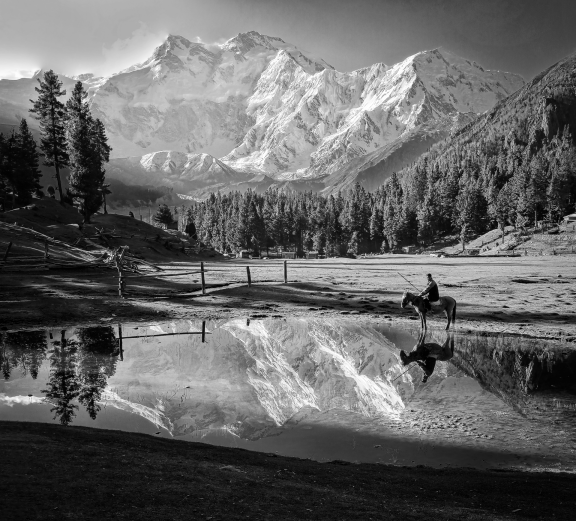

In [10]:
image = resize_img(cv2.imread('fairy-meadows.png', 0), 30)
image = image.astype(np.float64)
image = image/255.0
cv2_imshow(image*255.0)

### Imagem degradada

Usamos a função **generate_psf()** para degradá-la e retornar a Point Spread Function utilizada

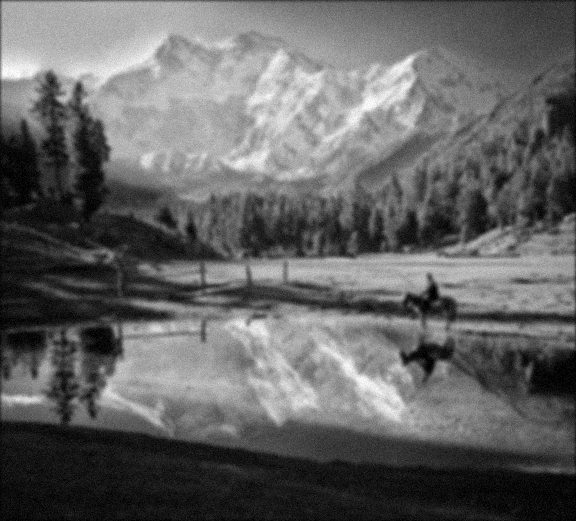

In [11]:
noised, psf = generate_psf(image, kernel_size=7, sigma=2.0, noise_coefficient=0.1)
cv2_imshow(noised*255.0)

## Estimativa dos limites inferior e superior do intervalo valores de coeficiente de balanço que será testado

Com o objetivo de definir um intervalo de valores para o coeficiente de balanço usados no filtro de Wiener para gerar as imagens restauradas, podemos inferir que existe um valor mínimo e um valor máximo para os quais a qualidade da imagem não é conveniente. Considerando que quanto menor for o coeficiente de balanço o ruído tende a aumentar e que quanto maior for o valor, o ruído tende a dimunir e borramento da imagem resultante tende a aumentar, o intervalo não deve considerar os valores menores que o valor mínimo (pois para eles o ruído aumentaria acima de um nível aceitável) e nem os valores maiores que o valor máximo (pois para eles o borramento aumetaria acima de um nível aceitável)

Com base nisso, buscamos obter os limites inferior e superior do intervalo para o qual os testes serão realizados

### Para o coeficiente de balanço = 0

Considerando o resultado abaixo para o valor 0 atribuído ao coeficiente de balanço, é fácil concluir que ele não deve nem mesmo ser considerado no intervalo devido ao nível de ruído obtido

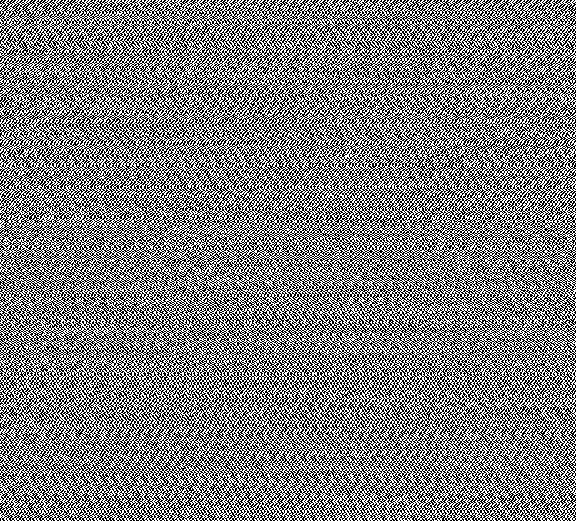

In [11]:
image_restoration(noised, psf, balance=0);

### Para o coeficiente de balanço = 0.01

Para o valor 0.01 o ruído é relativamente alto, mas a imagem é bem distinguível e ainda assim é um valor próximo de 0 (que claramente é um valor para o coeficiente de balanço para o qual o filtro de Weiner não fuinciona bem). Desta forma, é conveniente usar 0.01 como limite inferior, pois apresenta muito ruído, mas ao mesmo tempo não corrompe completamente a imagem como no caso do valor 0

Assim, escolhemos o 0.01 como o limite inferior do intervalo

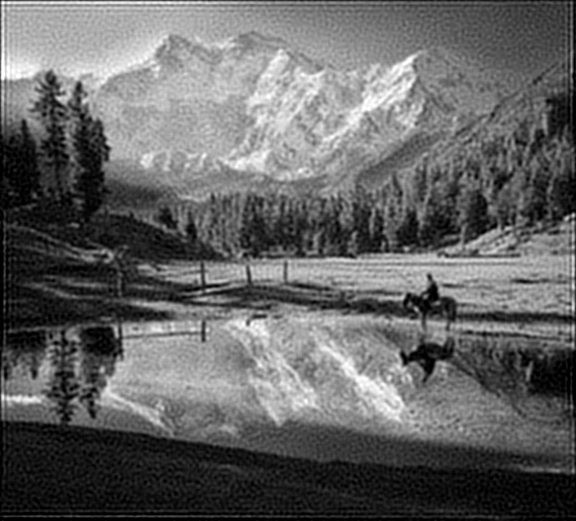

In [34]:
image_restoration(noised, psf, balance=0.01);

### Para o coeficiente de balanço = 5

Com o objetivo de obter o limite superior para o intervalo, analisamos inicialmente a qualidade da imagem para o coeficiente de balanço 5, como mostrado abaixo

O resultado é uma imagem com detalhes difíceis de distinguir, dado o nível borramento. Desta forma, podemos tomar 5 como o valor máximo para o intervalo pois sabemos que para ele a qualidade da imagem já está comprometida

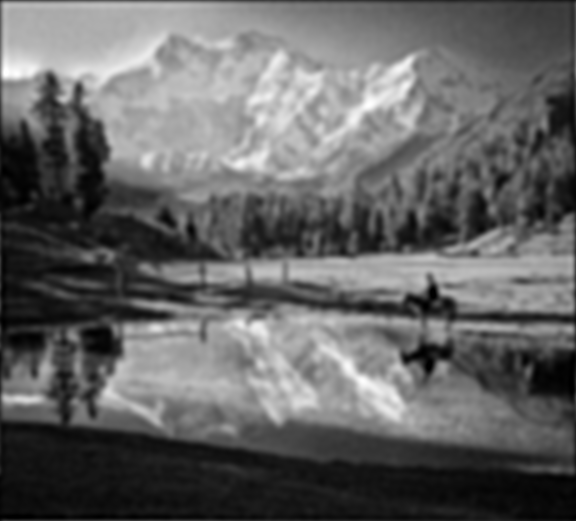

In [18]:
image_restoration(noised, psf, balance=5);

Como o limite inferior é 0.01 e o limite superior é 5, são razoáveis saltos de 0.01 entre os números que definirão o intervalo de valores discretos para os quais os testes serão realizados

Desta forma, obtemos 0.01 como o menor valor para o intervalo e 5 como o maior valor. Com isso, geramos um intervalo discreto de 0.01 até 5 com saltos de 0.01 em 0.01 a partir do valor inicial, gerando 500 valores totais no intervalo

## Estimativa automatizada do valor do coeficiente de balanceamento

### Geração da lista de coeficientes de balanceamento

Tendo os valores mínimo e máximo para o intervalo, a célula de código abaixo gera o intervalo de valores discretos para o coeficiente de balanço e os armazena na lista **balance_values**

In [23]:
balance_values = []
balance_value = 0
while (True):
  balance_value += 0.01
  balance_value = round(balance_value,2)
  balance_values.append(balance_value)
  if (balance_value == 5): break

In [27]:
len(balance_values)

500

In [35]:
print(balance_values)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.6, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1

### Obtenção da menor RMSE o seu índice correspondente

A célula abaixo aplica as funções **restored_images_list()** e **RMSE_evaluation()** de modo a gerar as imagens restauradas para cada coeficiente do intervalo definido e calcular a RMSE para cada uma delas, respectivamente. Uma vez obtidos os valores da RMSE, recuperamos o menor deles e o seu índice correspondente, que corresponde ao índice da imagem na lista **restored_images** com o melhor resultado da aplicação do filtro

O menor RMSE obtido foi **0.03038024870539491**

In [28]:
restored_images = restored_images_list(noised, psf, balance_values)
results = RMSE_evaluation(image, restored_images)
index = np.where(results == np.min(results))[0][0]
print('Menor RMSE',results[index])
print('Índice da menor RMSE', index)

Menor RMSE 0.03038024870539491
Índice da menor RMSE 4


### Melhor valor para o coeficiente de balanceamento dentre os valores do intervalo


Para esse caso (com o ceficiente de ruído de 0.1), o melhor valor obtido para o coeficente de balanceamento foi **0.05**

In [29]:
balance_values[index]

0.05

### Melhor resultado da aplicação do filtro para os valores de coeficiente de balanço no intervalo

Abaixo é mostrado a imagem correspondente ao melhor resultado da aplicação do filtro para os valores em **balance_values** (que corresponde a aplicação do filtro de Wiener com o coeficiente de balanceamento de 0.05)

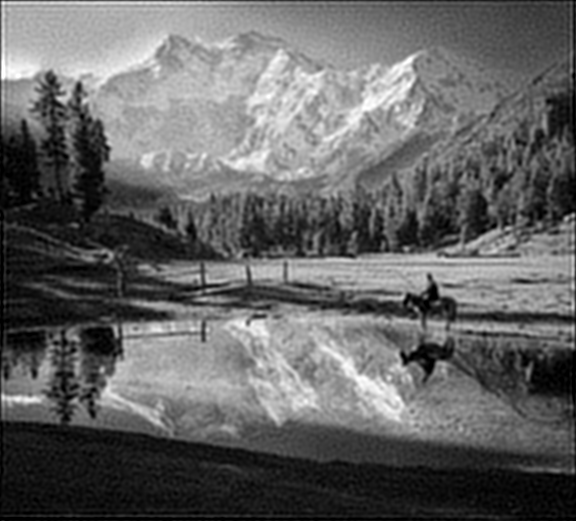

In [30]:
best_result = restored_images[index]*255.0
cv2_imshow(best_result)

## Comparação da imagem original com a degrada e a restaurada

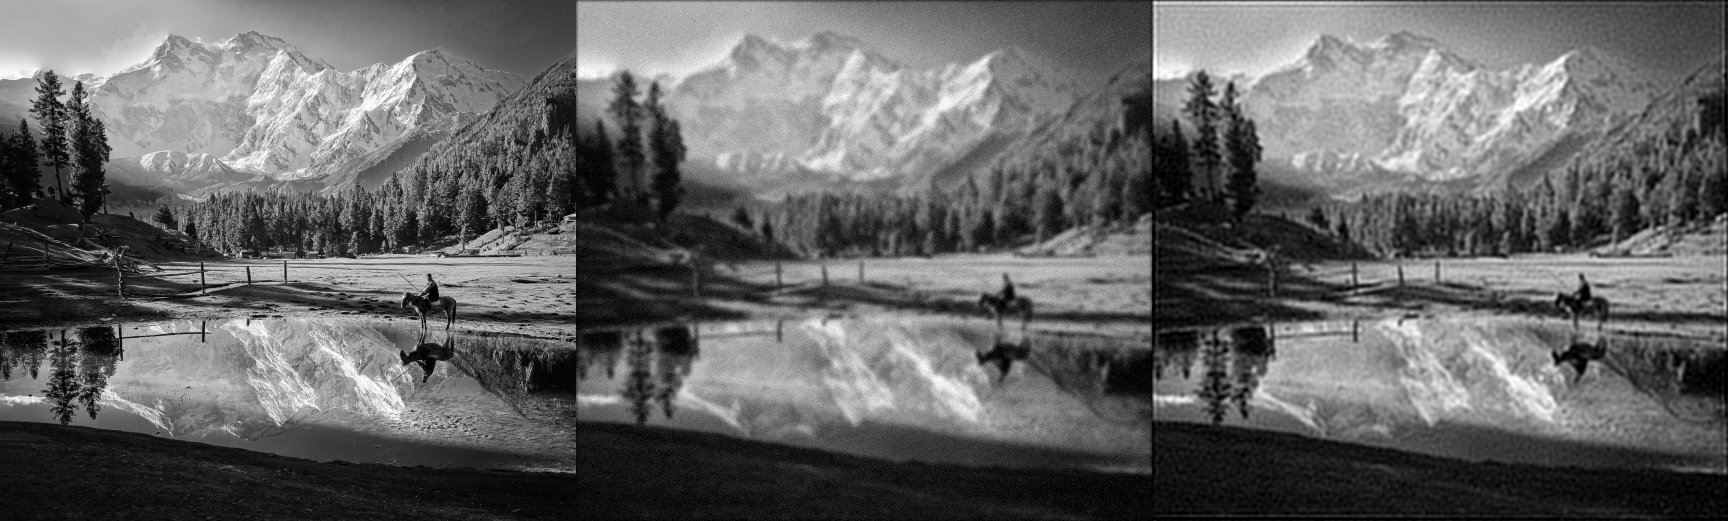

In [31]:
images = np.hstack((image*255.0, noised*255.0, best_result))
cv2_imshow(images)

Embora analisando subjetivamente possa parecer que a imagem restaurada apresenta mais ruído que a degradada, quando analisamos quantitavivamente podemos observar que o contrário é verdade e que de fato a aplicação do filtro de Wiener diminuiu o ruído na imagem resultante

In [33]:
noised_sigma_estimation = restoration.estimate_sigma(noised*255.0, True, True)
restored_sigma_estimation = restoration.estimate_sigma(best_result, True, True)
print('Ruído na imagem degradada:', noised_sigma_estimation)
print('Ruído na imagem restaurada:', restored_sigma_estimation)

Ruído na imagem degradada: 6.254932606856126
Ruído na imagem restaurada: 2.1313745802475594


## Conclusão

O resutlado obtido foi o melhor tendo em vista a abordagem da Raíz Quadrada do Erro Médio para os valores **do intervalo discreto considerado**. Se trata do melhor resultado dentro do intervalo considerado, mas não se pode dizer que é o melhor dentre os infinitos valores possíveis. Para uma melhor aproximação, pode-se utilizar a mesma estratégia mostrada nesse notebook para intervalos com valores mais limitados em cujos limites sabemos que o coeficiente que gera o melhor resutlado se encontra e então utilizar saltos menores entre os valores discretos desse intervalo